# CNN and KNN

## Libraries

In [1]:
import numpy as np
import cv2
import glob2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential,Input,Model, load_model
from keras.layers import Dense, Dropout, Flatten, SeparableConv2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras import backend as K
import sklearn.preprocessing as pre
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import pandas as pd
import seaborn as sn
import pickle, random
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import CondensedNearestNeighbour
import warnings
warnings.filterwarnings('ignore')
print("Keras version: {}".format(keras.__version__))
print("TensorFlow version: {}".format(tf.__version__))
%matplotlib inline

Using TensorFlow backend.


Keras version: 2.2.4
TensorFlow version: 1.10.0


## CNN

### Data Preparation

#### Loading MNIST

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train data shape: {0} | Train label shape: {1}".format(x_train.shape, y_train.shape))
print("Test data shape:  {0} | Test label shape:  {1}".format(x_test.shape, y_test.shape))

Train data shape: (60000, 28, 28) | Train label shape: (60000,)
Test data shape:  (10000, 28, 28) | Test label shape:  (10000,)


In [3]:
num_classes = len(np.unique(y_train))
print("Total classes: {}".format(num_classes))

Total classes: 10


Below is an example of training example at index=12 with label=3 (number three).

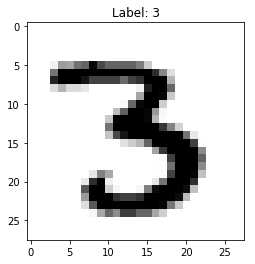

In [5]:
test_img = x_train[12].reshape(28, 28) # image size = 28x28
plt.imshow(test_img, cmap=cm.binary)
plt.title("Label: {}".format(y_train[12]))
plt.show()

#### Loading our own data

Loading our handwritten digit images and processed by scalling, converting to greyscale.

In [4]:
def process_image(file_name):
    image = cv2.imread(file_name, 0)
    image_resize = cv2.resize(image, (26,26))
    new_image = cv2.copyMakeBorder(image_resize, 1,1,1,1, cv2.BORDER_CONSTANT, value=[255,255,255])
    invert_image = cv2.bitwise_not(new_image)
    return invert_image

def load_images(img_path, num_classes):
    img_list = []
    label_list = []
    for i in range(0, num_classes):
        file_list = glob2.glob((img_path.format(i)))
        for file in file_list:
            label_list.append(i)
            image = process_image(file)
            image_reshape = image.reshape(1, 28, 28)
            img_list.append(image_reshape)

    num_image = len(img_list)
    my_stack = np.zeros((num_image, 28, 28))
    for j in range(num_image):
        my_stack[j] = img_list[j]

    label_reshape = np.asarray(label_list)
    return my_stack, label_reshape

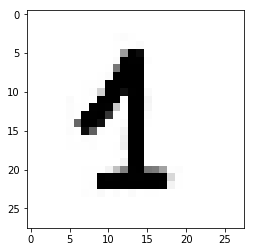

In [7]:
img = process_image("./data/train/1/example_7.jpeg")
plt.imshow(img, cmap=cm.binary)
plt.show()

In [5]:
train_path = "./data/train/{}/*.jpeg"
test_path = "./data/test/{}/*.jpeg"

train_stack, train_lbl = load_images(train_path, num_classes)
test_stack, test_lbl = load_images(test_path, num_classes)

In [9]:
train_stack.shape, train_lbl.shape

((500, 28, 28), (500,))

In [10]:
test_lbl

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9])

#### Format input data

Before building model, we have to make sure the input is in the same format with Keras input:

    input_shape = (28, 28, 1)    # image size: 28x28 and 1 is the channel for grayscale image
    data_format="channels_last"  # indicating the last value in input_shape is for the channel
    

In [6]:
x_train_reshape = x_train.reshape(-1, 28,28, 1)
x_test_reshape = x_test.reshape(-1, 28, 28, 1)

print("x_train new shape: {} | Data type: {}".format(x_train_reshape.shape, x_train_reshape.dtype))
print("x_test new shape:  {} | Data type: {}".format(x_test_reshape.shape, x_test_reshape.dtype))

x_train new shape: (60000, 28, 28, 1) | Data type: uint8
x_test new shape:  (10000, 28, 28, 1) | Data type: uint8


Re-shape our new data for both train and test set.

In [7]:
my_train_reshape = train_stack.reshape(-1, 28, 28, 1)
my_train_reshape.shape

(500, 28, 28, 1)

In [8]:
my_test_reshape = test_stack.reshape(-1, 28, 28, 1)
my_test_reshape.shape

(200, 28, 28, 1)

#### Normalization

Next, we have to normalize data by dividing each value to 255.

In [9]:
def normalize_data(input_data):
    data = input_data.astype(np.float32)
    return np.multiply(data, 1.0/255.0)

Normalization for MNIST data

In [10]:
x_train_norm = normalize_data(x_train_reshape)
x_test_norm = normalize_data(x_test_reshape)
print("Normalization is done.")

Normalization is done.


Normalization for our own data

In [11]:
my_train_data_norm = normalize_data(my_train_reshape)
my_test_data_norm = normalize_data(my_test_reshape)
print("Normalization is done.")
my_train_data_norm.shape, my_test_data_norm.shape

Normalization is done.


((500, 28, 28, 1), (200, 28, 28, 1))

In [28]:
my_test_data_norm[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [85]:
my_train_data_norm[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [84]:
x_train_norm[110]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

#### Label format

Because our labels data range from 0 to 9 for 10 digits, we need to convert them into one-hot vector before feeding into network.

In [12]:
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=10)
y_test_onehot = y_test_onehot.astype(int)

In [14]:
y_train_onehot = keras.utils.to_categorical(y_train, num_classes=10)
y_train_onehot = y_train_onehot.astype(int)

In [15]:
my_train_label_onehot = keras.utils.to_categorical(train_lbl, num_classes=num_classes)
my_train_label_onehot = my_train_label_onehot.astype(int)

In [16]:
my_test_label_onehot = keras.utils.to_categorical(test_lbl, num_classes=num_classes)
my_test_label_onehot = my_test_label_onehot.astype(int)

In [32]:
my_train_label_onehot[0:4], my_test_label_onehot[0:4]

(array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

Original labels of first 10 items:

In [92]:
y_train[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [93]:
y_test[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

Labels after converting:

In [94]:
y_train_onehot[0:10]

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [95]:
y_test_onehot[0:10]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [33]:
print("Training label shape: {}".format(y_train_onehot.shape))
print("Test label shape: {}".format(y_test_onehot.shape))

Training label shape: (60000, 10)
Test label shape: (10000, 10)


In [34]:
print("Training label shape: {}".format(my_train_label_onehot.shape))
print("Test label shape: {}".format(my_test_label_onehot.shape))

Training label shape: (500, 10)
Test label shape: (200, 10)


#### Splitting Data

In [17]:
x_train_data, x_valid_data, y_train_data, y_valid_data = train_test_split(x_train_norm, 
                                                    y_train_onehot, 
                                                    test_size = 0.15, 
                                                    random_state = 123)

print("Length of x_train: "+ str(x_train_data.shape))
print("Length of y_train: "+ str(y_train_data.shape) +"\n")
print("Shape of x_valid: "+ str(x_valid_data.shape))
print("Shape of y_valid: "+ str(y_valid_data.shape))

Length of x_train: (51000, 28, 28, 1)
Length of y_train: (51000, 10)

Shape of x_valid: (9000, 28, 28, 1)
Shape of y_valid: (9000, 10)


In [18]:
my_x_train, my_x_valid, my_y_train, my_y_valid = train_test_split(my_train_data_norm, my_train_label_onehot,
                                                                 test_size = 0.15,
                                                                 random_state = 123)

print("Length of my_x_train: "+ str(my_x_train.shape))
print("Length of my_y_train: "+ str(my_y_train.shape) +"\n")
print("Shape of my_x_valid: "+ str(my_x_valid.shape))
print("Shape of my_y_valid: "+ str(my_y_valid.shape))

Length of my_x_train: (425, 28, 28, 1)
Length of my_y_train: (425, 10)

Shape of my_x_valid: (75, 28, 28, 1)
Shape of my_y_valid: (75, 10)


### Modelling

This model architecture is based on my previous work with MNIST before. We will divide training data into batches and apply drop-out to prevent overfitting.

Eventhough we are not going to use CNN to predict the digit classes in the end, we still have to build the model and later extract the representation layer which is before the softmax layer and feed this into K Nearest Neighbors algorithm for classification task.

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(4, 4), padding='same', input_shape=(28,28,1), activation = 'relu'))
model.add(MaxPooling2D((2,2), padding = 'same'))
model.add(Dropout(0.1))
model.add(Conv2D(64, kernel_size = (4, 4), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D((2,2), padding = 'same'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [152]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training

In [148]:
saved_mode = "./model/cnn.h5"
batch_size = 64
num_epochs = 30

In [153]:
callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='acc', patience=2),
        keras.callbacks.ModelCheckpoint(filepath=saved_mode, monitor='val_loss',save_best_only=True)]

built_model = model.fit(x_train_data, y_train_data, 
                        batch_size=batch_size, epochs=num_epochs, 
                        verbose=1, validation_data=(x_valid_data, y_valid_data),
                        callbacks = callbacks_list)

Train on 51000 samples, validate on 9000 samples
Epoch 1/30
51000/51000 [==============================] - 157s 3ms/step - loss: 0.2469 - acc: 0.9229 - val_loss: 0.0540 - val_acc: 0.9847
Epoch 2/30
51000/51000 [==============================] - 155s 3ms/step - loss: 0.0849 - acc: 0.9760 - val_loss: 0.0465 - val_acc: 0.9864
Epoch 3/30
51000/51000 [==============================] - 163s 3ms/step - loss: 0.0744 - acc: 0.9800 - val_loss: 0.0394 - val_acc: 0.9876
Epoch 4/30
51000/51000 [==============================] - 158s 3ms/step - loss: 0.0735 - acc: 0.9815 - val_loss: 0.0423 - val_acc: 0.9874
Epoch 5/30
51000/51000 [==============================] - 158s 3ms/step - loss: 0.0771 - acc: 0.9813 - val_loss: 0.0570 - val_acc: 0.9869
Epoch 6/30
51000/51000 [==============================] - 163s 3ms/step - loss: 0.0836 - acc: 0.9812 - val_loss: 0.0433 - val_acc: 0.9884


In [154]:
def plotting(model):
    train_accuracy = model.history['acc']
    valid_accuracy = model.history['val_acc']
    train_loss = model.history['loss']
    valid_loss = model.history['val_loss']
    epch = range(1,len(train_accuracy)+1)
    plt.plot(epch, train_accuracy, 'bo', label='Training acc')
    plt.plot(epch, valid_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epch, train_loss, 'bo', label='Training loss')
    plt.plot(epch, valid_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

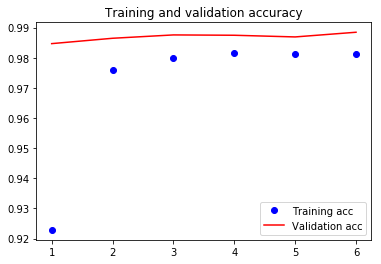

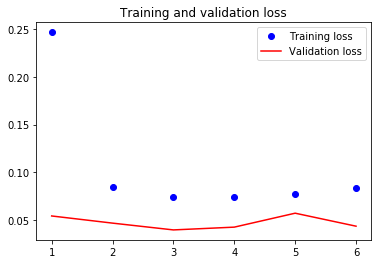

In [187]:
plotting(built_model)

In [168]:
saved_model = load_model("./model/cnn.h5")
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 3136)              0         
__________

In [214]:
saved_model = load_model("./model/cnn.h5")
test_values = saved_model.evaluate(x_test_norm, y_test_onehot, verbose=1)
print('Test loss: {0:.4f}'.format(test_values[0]))
print('Test accuracy: {0:.2f}%'.format(test_values[1]*100))

10000/10000 [==============================] - 10s 990us/step
Test loss: 0.0313
Test accuracy: 98.99%


In [169]:
for i in range(7):
    saved_model.pop()
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 7, 7, 64)          0         
Total params: 1,787,946
Trainable params: 1,787,946
Non-trainable params: 0
_________________________________________________________________


In [170]:
output = saved_model.output
output = Flatten()(output)
output = BatchNormalization()(output)
output = Dense(512, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(num_classes, activation = 'softmax')(output)
new_model = Model(saved_model.input, output)
for layer in saved_model.layers:
    layer.trainable = True
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35_input (InputLayer) (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 7, 7, 64)          0         
__________

In [171]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Using pre-trained MNIST model for new data

In [19]:
new_model_path = "./model/cnn_new_data.h5"
batch_size = 32
num_epochs = 20

In [183]:
callbacks_list_new = [
        keras.callbacks.EarlyStopping(monitor='acc', patience=2),
        keras.callbacks.ModelCheckpoint(filepath=new_model_path, monitor='val_loss',save_best_only=True)]

built_model_new = new_model.fit(my_x_train, my_y_train, 
                        batch_size=batch_size, epochs=num_epochs, 
                        verbose=1, validation_data=(my_x_valid, my_y_valid),
                        callbacks = callbacks_list_new)

Train on 425 samples, validate on 75 samples
Epoch 1/20
425/425 [==============================] - 2s 4ms/step - loss: 0.0115 - acc: 0.9976 - val_loss: 0.2774 - val_acc: 0.9333
Epoch 2/20
425/425 [==============================] - 2s 4ms/step - loss: 0.0113 - acc: 0.9953 - val_loss: 0.2715 - val_acc: 0.9333
Epoch 3/20
425/425 [==============================] - 2s 4ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.2538 - val_acc: 0.9333
Epoch 4/20
425/425 [==============================] - 2s 4ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.2510 - val_acc: 0.9333
Epoch 5/20
425/425 [==============================] - 2s 4ms/step - loss: 0.0149 - acc: 0.9906 - val_loss: 0.2761 - val_acc: 0.9333


### Predicting

In [69]:
# visualize confusion matrix on heat map
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.show()

In [65]:
def predict_data(model_path, test_data, test_label):
    model = load_model(model_path)
    values = model.evaluate(test_data, test_label, verbose=1)
    print('Test loss: {0:.4f}'.format(values[0]))
    print('Test accuracy: {0:.2f}%'.format(values[1]*100))
    pred = model.predict(test_data)
    argmax_pred = []
    argmax_true = []
    for i in range(pred.shape[0]):
        argmax_pred.append(np.argmax(pred[i]))
        argmax_true.append(np.argmax(test_label[i]))
    argmax_pred_reshape = np.reshape(argmax_pred, (pred.shape[0],))
    argmax_true_reshape = np.reshape(argmax_true, (test_label.shape[0]))
    print_cmx(argmax_true_reshape, argmax_pred_reshape)
    return values[1] # as test accuracy

In [20]:
test_data_all = np.concatenate((x_test_norm, my_test_data_norm))
test_label_onehot_all = np.concatenate((y_test_onehot, my_test_label_onehot))

200/200 [==============================] - 2s 8ms/step
Test loss: 0.1957
Test accuracy: 95.50%


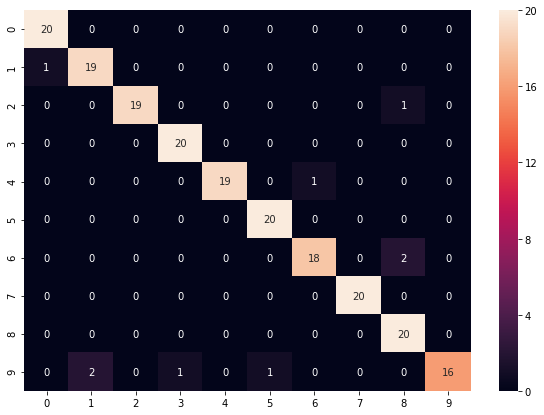

In [186]:
cnn_accuracy = predict_data(new_model_path, my_test_data_norm, my_test_label_onehot)

## Feature Extraction

In [188]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35_input (InputLayer) (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 7, 7, 64)          0         
__________

In [189]:
for i in range(len(new_model.layers)):
    print(i, new_model.layers[i])

0 <keras.engine.input_layer.InputLayer object at 0x172163080>
1 <keras.layers.convolutional.Conv2D object at 0x172163ef0>
2 <keras.layers.pooling.MaxPooling2D object at 0x1702762b0>
3 <keras.layers.core.Dropout object at 0x17026e668>
4 <keras.layers.convolutional.Conv2D object at 0x17026e6a0>
5 <keras.layers.pooling.MaxPooling2D object at 0x170263b38>
6 <keras.layers.core.Dropout object at 0x1702765f8>
7 <keras.layers.core.Flatten object at 0x1701e84a8>
8 <keras.layers.normalization.BatchNormalization object at 0x1701e8080>
9 <keras.layers.core.Dense object at 0x1701e8208>
10 <keras.layers.normalization.BatchNormalization object at 0x155600710>
11 <keras.layers.core.Dropout object at 0x1555df748>
12 <keras.layers.core.Dense object at 0x155644438>


Use Keras function that will return the output of a certain layer given a certain input,

In [190]:
feature_layer = K.function([new_model.layers[0].input, K.learning_phase()], [new_model.layers[11].output])

In [191]:
train_feature_input = feature_layer([x_train_norm,0])[0]

In [193]:
train_feature_input[0]

array([-6.67253137e-01, -3.05039108e-01,  1.51819491e+00, -2.77686715e-01,
        5.20219266e-01, -6.34675622e-01, -6.49952590e-01,  3.51664066e-01,
       -5.10749102e-01, -7.19652176e-01, -3.28778476e-01, -5.14026821e-01,
        1.80724144e-01, -7.31613815e-01,  1.37848556e-01, -5.82546234e-01,
       -6.39344037e-01, -3.80570859e-01, -5.40629685e-01, -7.65654266e-01,
       -6.61790729e-01, -6.47894084e-01, -6.36330962e-01,  8.02309513e-01,
       -5.89201272e-01,  4.82481599e-01,  2.34344780e-01, -3.18875641e-01,
        1.99898243e+00, -6.12493396e-01,  4.82610106e-01, -7.31030822e-01,
       -6.84491217e-01, -6.81175470e-01, -6.06058538e-01,  8.26598525e-01,
       -6.12829685e-01, -6.63494110e-01,  2.41095614e+00, -6.88082397e-01,
       -4.46872771e-01, -6.96543813e-01, -6.56964123e-01,  4.07202065e-01,
       -3.89445692e-01,  1.16709828e+00,  7.72596836e-01, -6.42564058e-01,
       -4.44006741e-01,  5.60025394e-01,  2.27935839e+00, -6.45498276e-01,
       -6.74732983e-01, -

In [192]:
my_train_feature_input = feature_layer([my_train_data_norm,0])[0]
my_train_feature_input[0]

array([ 1.9117984 , -0.6687851 , -0.01378721, -0.16986597, -0.65015453,
        0.41781664,  1.1675944 ,  0.6021684 ,  3.4620242 , -0.54962313,
        1.5066328 , -0.70541936,  0.41443145, -0.0055663 , -0.744666  ,
       -0.58254623, -0.63934404,  0.00504357, -0.5406297 , -0.76565427,
       -0.6617907 , -0.6478941 , -0.63633096, -0.67513084, -0.5892013 ,
       -0.7094102 , -0.36284387,  0.806893  ,  1.4349303 , -0.05318195,
        2.0708823 , -0.7310308 , -0.6844912 ,  3.187277  ,  2.7114787 ,
       -0.66111434,  0.35457897,  1.5643177 , -0.72279006, -0.07348549,
       -0.6582082 , -0.7113019 ,  1.879251  , -0.7376873 , -0.7675798 ,
        2.346258  ,  4.3316154 , -0.7814844 , -0.6830964 , -0.6720026 ,
       -0.6452339 , -0.6454983 , -0.674733  , -0.6364167 , -0.62782633,
        0.66179246, -0.64718425,  2.6313841 ,  0.7064056 ,  0.13934839,
       -0.59480006, -0.6664519 ,  0.23797715, -0.6389599 , -0.61115324,
       -0.6379175 , -0.64771026,  2.6491513 ,  0.7232112 , -0.52

In [194]:
test_feature_input = feature_layer([x_test_norm,0])[0]

In [196]:
test_feature_input[0]

array([-6.67253137e-01,  1.01946032e+00,  4.44167495e-01,  3.25551748e-01,
        8.01229417e-01, -6.34675622e-01, -6.49952590e-01, -6.20842755e-01,
        1.71168685e-01, -7.19652176e-01, -6.02152824e-01,  1.18288541e+00,
       -6.13844693e-01,  4.45135057e-01,  1.97141397e+00, -4.78847146e-01,
        2.50110447e-01, -7.85737872e-01, -5.40629685e-01, -7.65654266e-01,
        7.00794816e-01,  1.09520054e+00, -6.36330962e-01, -6.75130844e-01,
       -5.89201272e-01,  7.34486699e-01, -6.99252427e-01, -7.73018718e-01,
        3.85915875e-01, -8.95147324e-02, -6.16304040e-01,  1.27388990e+00,
       -6.84491217e-01, -6.81175470e-01, -6.06058538e-01,  4.43137527e-01,
       -6.70220256e-01, -6.63494110e-01, -1.89086795e-02, -6.88082397e-01,
        1.28103542e+00, -7.11301923e-01, -6.56964123e-01, -7.37687290e-01,
        8.01742435e-01, -7.43771553e-01, -6.41221762e-01,  2.49164283e-01,
       -6.83096409e-01, -6.72002614e-01, -6.45233929e-01,  1.64064121e+00,
       -6.74732983e-01,  

In [195]:
my_test_feature_input = feature_layer([my_test_data_norm,0])[0]
my_test_feature_input[0]

array([ 2.220561  , -0.43151966, -0.57449365,  0.20838642, -0.65015453,
       -0.16467994,  0.1412605 ,  0.64866346,  1.2669147 ,  0.66523314,
        1.6044936 , -0.70541936,  1.0732439 , -0.7316138 , -0.744666  ,
       -0.58254623, -0.63934404, -0.15169418, -0.5406297 , -0.76565427,
       -0.6617907 , -0.6478941 , -0.63633096, -0.67513084, -0.35843456,
       -0.7094102 , -0.6992524 ,  1.7385458 , -0.5236036 ,  0.36848277,
        1.9778215 ,  1.5615481 , -0.6844912 ,  1.7872097 ,  1.1173136 ,
       -0.66111434,  1.0597836 ,  1.6619902 , -0.72279006,  1.1221745 ,
       -0.6582082 , -0.7113019 ,  3.0544796 , -0.7376873 , -0.06299025,
        0.7127992 ,  0.8857933 , -0.37079558, -0.6830964 ,  1.6368523 ,
       -0.6452339 , -0.6454983 , -0.3808801 , -0.6364167 , -0.62782633,
       -0.33664104, -0.64718425,  2.7098525 , -0.59560555, -0.6188835 ,
        0.78374344, -0.6664519 , -0.09827334,  0.44704878, -0.61115324,
       -0.6379175 , -0.64771026,  2.228726  , -0.76189476, -0.52

## K Nearest Neighbor

### Gridsearch

In this part we will use `GridSearchCV` to find the best parameters for the KNN model using feature extraction data for training and original labels.

In [208]:
sqrt_N = (np.sqrt(my_train_data_norm.shape[0])).astype(int)
params = {"n_neighbors": [3,5,7,11,25,sqrt_N],
              "weights": ['uniform', 'distance']}
knn_classifier = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_classifier, param_grid=params, cv=4)
grid_search_knn.fit(my_train_feature_input, train_lbl)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [3, 5, 7, 11, 25, 22], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [209]:
my_train_feature_input.shape

(500, 512)

In [210]:
y_train.shape, train_lbl.shape

((60000,), (500,))

In [211]:
best_classifier = grid_search_knn.best_estimator_
best_knn_model = best_classifier.fit(my_train_feature_input, train_lbl)

### Predicting

In [212]:
y_test_knn = best_knn_model.predict(my_test_feature_input)
accuracy_knn = accuracy_score(test_lbl, y_test_knn)
print(classification_report(test_lbl, y_test_knn))
print("KNN Test Accuracy: {0:.3f}%".format(accuracy_knn*100))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.74      1.00      0.85        20
           2       1.00      1.00      1.00        20
           3       0.91      1.00      0.95        20
           4       1.00      0.85      0.92        20
           5       1.00      1.00      1.00        20
           6       0.95      0.95      0.95        20
           7       1.00      1.00      1.00        20
           8       0.95      0.95      0.95        20
           9       1.00      0.75      0.86        20

   micro avg       0.94      0.94      0.94       200
   macro avg       0.95      0.94      0.95       200
weighted avg       0.95      0.94      0.95       200

KNN Test Accuracy: 94.500%


### Save Classifier

In [238]:
with open('./data/best_classifier.pkl', 'wb') as f:
    pickle.dump(best_classifier, f)
#with open('./data/best_classifier.pkl', 'rb') as f:
    #best_classifier_loaded = pickle.load(f)

## Metric Learning

In [37]:
from pylmnn import LargeMarginNearestNeighbor as LMNN

In [31]:
feature_layer = K.function([new_loaded_model.layers[0].input, K.learning_phase()], [new_loaded_model.layers[11].output])
my_train_feature_input = feature_layer([my_train_data_norm,0])[0]
my_test_feature_input = feature_layer([my_test_data_norm,0])[0]

In [36]:
my_train_feature_input.shape, train_lbl.shape, my_test_feature_input.shape, test_lbl.shape

((500, 512), (500,), (200, 512), (200,))

In [66]:
# Ref: https://github.com/johny-c/pylmnn
# Set up the hyperparameters
n_neighbors = 7
max_iter = 10

# Instantiate the metric learner
lmnn = LMNN(n_neighbors=n_neighbors,verbose=1, max_iter=max_iter)

# Train the metric learner
lmnn.fit(my_train_feature_input, train_lbl)

# Fit the nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors = n_neighbors)
knn.fit(lmnn.transform(my_train_feature_input), train_lbl)

# Compute the k-nearest neighbor test accuracy after applying the learned transformation
lmnn_acc = knn.score(lmnn.transform(my_test_feature_input), test_lbl)

[LargeMarginNearestNeighbor] Finding principal components...
[LargeMarginNearestNeighbor] Found principal components in  0.15s.
[LargeMarginNearestNeighbor] Finding the target neighbors...
[LargeMarginNearestNeighbor] Found the target neighbors in  0.06s.
[LargeMarginNearestNeighbor] Computing static part of the gradient...
[LargeMarginNearestNeighbor] Computed static part of the gradient in  0.05s.
[LargeMarginNearestNeighbor]
[LargeMarginNearestNeighbor]  Iteration      Objective Value     #Active Triplets    Time(s)
[LargeMarginNearestNeighbor] ---------------------------------------------------------------
[LargeMarginNearestNeighbor]          1         1.093096e+07                  985       0.19
[LargeMarginNearestNeighbor]          1         1.917958e+06                  265       0.20
[LargeMarginNearestNeighbor]          2         1.669437e+06                  218       0.15
[LargeMarginNearestNeighbor]          3         1.346716e+06                   96       0.14
[LargeMarg

# Final Results

Below are the results from the CNN and CNN features + KNN sklearn:

In [218]:
print('Own data CNN Test accuracy: {0:.3f}%'.format(cnn_accuracy*100))
print('Own data CNN features+KNN Test Accuracy: {0:.3f}%'.format(accuracy_knn*100))

Own data CNN Test accuracy: 95.500%
Own data CNN features+KNN Test Accuracy: 94.500%


In [67]:
print('Own data LMNN Test accuracy: {:.3f}'.format(lmnn_acc))

Own data LMNN Test accuracy: 0.970


### Steps to test with our drawing image

    1. Load save keras model
    2. Load feature layers
    3. Pre-process, resize, normalize and reshape input image to (-1, 28, 28, 1) 
    4. Get feature values for normalize image
    5. Load best classifier (pickle file) to predict data

In [22]:
with open('./data/best_classifier.pkl', 'rb') as f:
    best_classifier_loaded = pickle.load(f)
best_classifier_loaded

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [23]:
new_model_path = "./model/cnn_new_data.h5"
new_loaded_model = load_model(new_model_path)
new_loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35_input (InputLayer) (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 32)        544       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 7, 7, 64)          0         
__________

In [24]:
loaded_feature_layer = K.function([new_loaded_model.layers[0].input, K.learning_phase()], 
                                  [new_loaded_model.layers[11].output])

(28, 28)


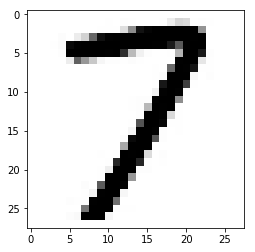

In [50]:
img = process_image("./data/test/7/f934c329-e65d-4964-93d1-f77cee0ff1a4-7.jpeg")
print(img.shape)
plt.imshow(img, cmap=cm.binary)
plt.show()

In [45]:
demo_img_norm = normalize_data(img)
demo_img_reshape = demo_img_norm.reshape(-1, 28,28, 1)

In [46]:
demo_input = loaded_feature_layer([demo_img_reshape,0])[0]

In [49]:
demo_input.shape

(1, 512)

In [47]:
y_test_knn = best_classifier_loaded.predict(demo_input)
y_test_knn

array([7])

# References

1. Doan Tu My, CNN with MNIST - https://github.com/doantumy/CNN-with-MNIST/
- Aditya Sharma, Convolutional Neural Networks in Python with Keras - https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
- Han Xiao et.al. - Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms - https://arxiv.org/abs/1708.07747
- Sebastian Raschka, Vahid Mirjalili, Python Machine Learning Book - 2nd edition -https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning-second-edition
- Group Project from 1st semester - https://github.com/ajoseph12/Protein_Alignment_Minimum_Edit_Distance
- Keras, Document, Convolutional Layers - https://keras.io/layers/convolutional/
- Keras Document - https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
- Shibuiwilliam, Keras_Sklearn - https://github.com/shibuiwilliam/Keras_Sklearn
- John Chiotellis, LMNN - https://github.com/johny-c/pylmnn